# Predicting Wind Turbine Yield

Dataset is available here: https://www.kaggle.com/datasets/psycon/wind-turbine-energy-kw-generation-data

...

Workflow:
- checking differences in output power between years: looking for year-to-year differences
- looking for a seasonal trend
- identifying correlations
- data cleaning

Methods:
- we can explore time-series based, but also other methods

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, kpss, ccf

In [2]:
def remove_outliers_iqr(X, cols):
    for col in cols:
        feature = X[col]
        q1 = feature.quantile(0.25)
        q3 = feature.quantile(0.75)
        iqr = q3 - q1
        mask = feature.loc[((feature < (q1 - 1.5 * iqr)) | (feature > (q3 + 1.5 * iqr)))].index
        X.loc[mask, col] = np.nan
    return X

## Loading the data

In [3]:
feature_units = pd.read_csv("kaggle_dataset/feature_units.csv")
features = pd.read_csv("kaggle_dataset/features.csv", index_col="Timestamp")
features.index = pd.to_datetime(features.index)

power = pd.read_csv("kaggle_dataset/power.csv", index_col="Timestamp")
power.index = pd.to_datetime(power.index)

In [4]:
feature_units.shape, features.shape, power.shape

((77, 2), (154262, 76), (136730, 1))

In [5]:
feature_units.head(3)

,Column,Unit
0,Timestamp,()
1,Gearbox_T1_High_Speed_Shaft_Temperature,(°C)
2,Gearbox_T3_High_Speed_Shaft_Temperature,(°C)


In [6]:
power.head(3)

,Power(kW)
Timestamp,
2019-01-01 00:00:00,705.876648
2019-01-01 00:10:00,884.711670
2019-01-01 00:20:00,982.875000


In [7]:
features.index.min(), features.index.max()

(Timestamp('2019-01-01 00:00:00'), Timestamp('2021-12-14 23:50:00'))

In [8]:
dataset_days = round(features.index.shape[0] / (6*24))
print(f"This dataset consists of {dataset_days} days")

This dataset consists of 1071 days


## Data Cleaning
Time series methods might have different handling of outliers, as we cannot simply drop them

In [9]:
power.isna().sum()

Power(kW)    0
dtype: int64

In [10]:
nans_per_feature = features.isna().sum()
nans_per_feature.loc[nans_per_feature > 5000]

Gearbox_Oil_Temperature                              5176
Moment D Direction                                   5231
Temperature Heat Exchanger Converter Control Unit    5186
Pitch Offset-1 Asymmetric Load Controller            5023
Wind Deviation 10 seconds                            5132
Proxy Sensor_Degree-135                              5337
Pitch Demand Baseline_Degree                         5188
Blade-1 Set Value_Degree                             5506
Moment Q Filltered                                   5160
dtype: int64

In [11]:
# cols_to_drop = list(nans_per_feature[nans_per_feature > 5000].index)  # drop features which have more than 20% NaNs
# features.drop(columns=cols_to_drop, inplace=True)
# print("Dropping:", cols_to_drop)

# print("Before dropping rows with NaNs:", X.shape)
# X.dropna(inplace=True)
# y = y.loc[X.index]
# print("After dropping rows with NaNs:", X.shape)

### Investigating correlations

<AxesSubplot:>

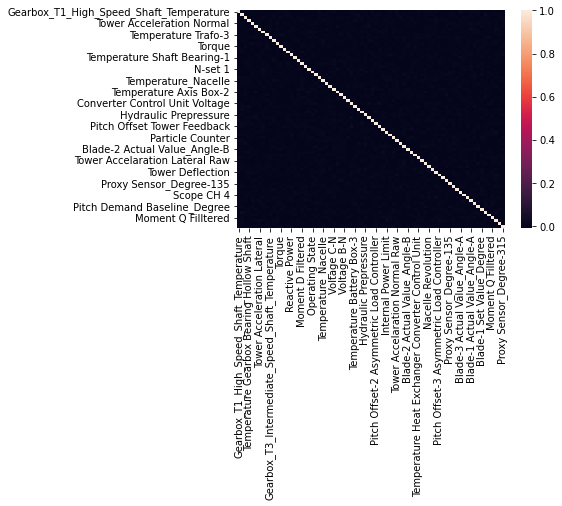

In [12]:
corr_matrix = features.corr()
sns.heatmap(corr_matrix)

In [13]:
corr_matrix[corr_matrix < 1].max().max()

0.02507789554864021

In [14]:
corr_matrix[corr_matrix > -1].min().min()

-0.009218213751575331

In [15]:
variance = features.var()
variance.sort_values(ascending=True)

N-set 1                                              7.726238e+07
External Power Limit                                 7.754728e+07
Gearbox_Oil_Temperature                              7.942934e+07
Nacelle Revolution                                   7.974133e+07
Temperature Heat Exchanger Converter Control Unit    8.012646e+07
                                                         ...     
Line Frequency                                       9.161401e+07
Temperature Battery Box-1                            9.197995e+07
Gearbox_T1_Intermediate_Speed_Shaft_Temperature      9.221544e+07
Torque                                               9.337851e+07
Blade-1 Actual Value_Angle-A                         9.348584e+07
Length: 76, dtype: float64

### Looking for duplicates

In [16]:
features.duplicated().sum()

0

### Looking for outliers

In [17]:
features_per_unit = feature_units.groupby('Unit').count().T
features_per_unit.columns

Index(['( )', '(%)', '()', '(Hz)', '(Nm)', '(V)', '(bar)', '(kNm)', '(kVAr)',
       '(kW)', '(mm)', '(mm/s²)', '(ms)', '(rpm)', '(°)', '(°C)'],
      dtype='object', name='Unit')

Temperatures in wind turbines do not reach 99999°C, these are missing values. After cleaning the temperatures seem realistic.

In [18]:
temperature_features = feature_units.loc[feature_units['Unit'] == '(°C)', 'Column'].to_list()

In [19]:
# Replaing 99999 in all features with a NaN
for col in features.columns:
    features[col].loc[features[col] == 99999] = np.nan

In [20]:
features[temperature_features].max()

Gearbox_T1_High_Speed_Shaft_Temperature               70.593330
Gearbox_T3_High_Speed_Shaft_Temperature               73.000000
Gearbox_T1_Intermediate_Speed_Shaft_Temperature       65.889999
Temperature Gearbox Bearing Hollow Shaft              68.866669
Gearbox_Oil-2_Temperature                             70.646667
Temperature Bearing_A                                 74.000000
Temperature Trafo-3                                  124.000000
Gearbox_T3_Intermediate_Speed_Shaft_Temperature       68.866669
Gearbox_Oil-1_Temperature                             66.000000
Gearbox_Oil_Temperature                               66.000000
Temperature Trafo-2                                  132.000000
Temperature Shaft Bearing-1                           52.000000
Gearbox_Distributor_Temperature                       63.000000
Temperature Shaft Bearing-2                           47.000000
Temperature_Nacelle                                   45.000000
Temperature Axis Box-3                  

Angles should not be outside of the 0-360 degree range. What to do with negative angles?

In [21]:
angle_features = feature_units.loc[feature_units['Unit'] == '(°)', 'Column'].to_list()

In [22]:
features[angle_features].describe()

,Nacelle Position_Degree,Angle Rotor Position,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Blade-2 Actual Value_Angle-B,Blade-1 Actual Value_Angle-B,Blade-3 Actual Value_Angle-B,Pitch Offset-1 Asymmetric Load Controller,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,Blade-3 Actual Value_Angle-A,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree
count,148067.000000,148123.000000,148525.000000,148044.000000,148667.000000,148552.000000,148426.000000,148031.000000,148390.000000,148495.000000,147881.000000,148214.000000,149049.000000,148057.000000,148529.000000,147700.000000,147476.000000,148196.000000
mean,224.855378,176.385149,0.001591,0.000069,-0.001401,0.002916,0.025504,-0.001027,-0.000540,0.165730,0.102835,12.048136,13.221061,12.790983,13.745315,13.132516,13.265793,12.714215
std,129.489572,62.341272,0.033312,0.000648,3.604065,3.792858,15.084957,0.024782,0.009677,17.443635,17.216803,27.378735,26.451703,26.480270,24.010688,24.099226,24.108572,24.400876
min,0.000000,0.021802,-0.051858,-0.018136,-1081.238403,-1020.979675,-2116.335205,-0.915738,-0.544472,-180.000000,-180.000000,-408.779999,-408.779999,-408.779999,-0.128618,0.000000,-0.766988,-1.176853
25%,140.732498,178.235809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.108333,-2.110000,-0.694361,0.650163,0.075745,0.652280,0.000000,0.078312,-0.693729
50%,248.130005,179.533752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.928333,-0.930000,-0.008161,1.198493,0.662204,1.158399,0.589161,0.747486,0.000000
75%,346.000000,180.623398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.271667,0.261667,9.704880,10.998407,10.348921,11.084917,10.380007,10.574157,9.918951
max,359.998322,999.000000,1.338862,0.011111,872.919556,863.686768,5388.166016,0.048435,0.049967,167.093338,167.053329,90.442055,91.078819,91.256783,89.890266,89.594681,89.409424,89.579582


(-100.0, 100.0)

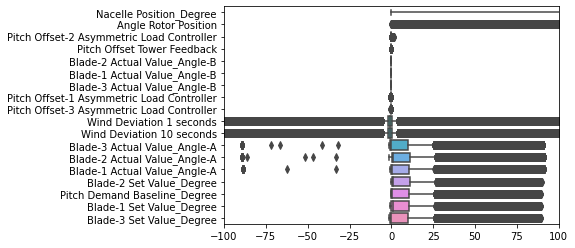

In [23]:
sns.boxplot(data=features[angle_features], orient='h')
plt.xlim([-100, 100])

### Removing outliers

In [24]:
# Remaining features
other = set(features.columns) - set(temperature_features + angle_features)
# features = remove_outliers_iqr(features, other)

In [25]:
features[other].isna().sum()

C:\Users\danie\AppData\Local\Temp\ipykernel_18176\3614559215.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  features[other].isna().sum()


Tower Accelaration Lateral Raw           5678
Particle Counter                         6000
Internal Power Limit                     5487
Voltage A-N                              5974
Converter Control Unit Reactive Power    5784
Converter Control Unit Voltage           5911
Torque                                   5527
Turbine State                            5535
Power Factor                             6353
Reactive Power                           5684
Torque Offset Tower Feedback             5528
Proxy Sensor_Degree-225                  6095
Proxy Sensor_Degree-315                  6115
Operating State                          5140
Line Frequency                           5271
Circuit Breaker cut-ins                  4997
Tower Accelaration Normal Raw            5985
External Power Limit                     5689
Moment Q Filltered                       6403
State and Fault                          5385
Moment D Filtered                        5869
Proxy Sensor_Degree-135           

## Exploratory Data Analysis

In [27]:
# Test for stationarity
y = power['Power(kW)']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KeyboardInterrupt: 

In [ ]:
power.groupby(power.index.year).rolling(6*24*7).mean().groupby(power.index.year).plot()